In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scikitplot as skplt

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [2]:
# import the all_data file
df_all = pd.read_csv('all_matches_all_data3.csv')
len(df_all)

/Users/lukebetham/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (42,54,345,346,347,348) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


94390

In [3]:
# # remove players with few stats
# df_v = df_all[['p1_last_name','p2_last_name']].apply(pd.Series.value_counts).fillna(0)
# df_v["total"] = df_v.p1_last_name + df_v.p2_last_name
# df_v=df_v[df_v["total"]<10]
# df_all=df_all[(~df_all['p1_last_name'].isin(df_v.index))|(~df_all['p1_last_name'].isin(df_v.index))]
# len(df_all)

In [4]:
df_all.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94390 entries, 0 to 94389
Data columns (total 358 columns):
match_id                           94390 non-null int64
tournament_event_id                94390 non-null int64
match_num                          94390 non-null int64
date                               94390 non-null object
surface                            94205 non-null object
indoor                             94390 non-null bool
round                              94390 non-null object
best_of                            94390 non-null int64
winner_id                          94390 non-null int64
winner_country_id                  94390 non-null object
winner_seed                        38020 non-null float64
winner_entry                       11167 non-null object
winner_rank                        93713 non-null float64
winner_rank_points                 92684 non-null float64
winner_elo_rating                  94390 non-null float64
winner_next_elo_rating             943

In [5]:
# checking what the predictive power of the bookies is
odds_check = df_all.w_mean_prob-df_all.l_mean_prob
print("Picking the odds favorite means you will be correct:")
len(odds_check.dropna()[odds_check>=0])/len(odds_check.dropna())

Picking the odds favorite means you will be correct:


0.7020665752786902

In [6]:
# converting all date columns to dates
df_all.date = pd.to_datetime(df_all.date)
df_all.p1_dob = pd.to_datetime(df_all.p1_dob)
df_all.p2_dob = pd.to_datetime(df_all.p2_dob)
# turning prize money into int
df_all.p1_prize_money.fillna(0,inplace=True)
df_all.p2_prize_money.fillna(0,inplace=True)
df_all.p1_prize_money.replace(r'[a-zA-Z$<,\-]', '', regex=True, inplace=True)
df_all.p1_prize_money = df_all.p1_prize_money.apply(lambda x: float(str(x).split()[0]))
df_all.p2_prize_money.replace(r'[a-zA-Z$<,\-]', '', regex=True, inplace=True)
df_all.p2_prize_money = df_all.p1_prize_money.apply(lambda x: float(str(x).split()[0]))

In [7]:
# deal with NaNs for predictor columns
df_filt = df_all.copy()
# filling missing ranks as the lowest possible rank
df_filt.winner_rank = df_filt.winner_rank.fillna(np.min(df_all.winner_rank))
df_filt.loser_rank = df_filt.loser_rank.fillna(np.min(df_all.loser_rank))
# drop NaN for age
df_filt.dropna(subset=['p1_dob', 'p2_dob'],inplace=True)
# fill height with average height
df_filt.winner_height.fillna(df_filt.winner_height.mean(),inplace=True)
df_filt.loser_height.fillna(df_filt.loser_height.mean(),inplace=True)

# removing games with match info
df_filt.dropna(subset=['p1_p_matches', 'p2_p_matches'],inplace=True)

# removing games with no stats
df_filt.dropna(subset=['p1_p_ace', 'p2_p_ace'],inplace=True)
df_filt.dropna(subset=['p1_minutes', 'p2_minutes'],inplace=True)

# fill NaN for rivalries with 0
df_filt.p1_beat_p2_overall.fillna(0,inplace=True)
df_filt.p2_beat_p1_overall.fillna(0,inplace=True)
df_filt.p1_pct_overall.fillna(0,inplace=True)
df_filt.p2_pct_overall.fillna(0,inplace=True)
df_filt.p1_beat_p2_overall_all.fillna(0,inplace=True)
df_filt.p2_beat_p1_overall_all.fillna(0,inplace=True)
df_filt.p1_pct_overall_all.fillna(0,inplace=True)
df_filt.p2_pct_overall_all.fillna(0,inplace=True)

# # drop NaNs for rivalrys (big loss of data) - but huge increase in accuracy must not be correct
# df_filt.dropna(subset=['p1_beat_p2_overall', 'p2_beat_p1_overall','p1_pct_overall','p2_pct_overall'],inplace=True)
# df_filt.dropna(subset=['p1_beat_p2_overall_all','p2_beat_p1_overall_all','p1_pct_overall_all','p2_pct_overall_all'],inplace=True)





In [8]:
# checking what the predictive power of the bookies is after dropping NaNs
odds_check = df_filt.w_mean_prob-df_filt.l_mean_prob
print("Picking the odds favorite means you will be correct:")
len(odds_check.dropna()[odds_check>=0])/len(odds_check.dropna())

Picking the odds favorite means you will be correct:


0.6948342037374945

In [9]:
len(df_filt)

66908

In [13]:
# split the dataframe into two to have win/loss
df_win = df_filt.copy()
df_lose = df_filt.copy()
y = [1]*len(df_win)+[0]*len(df_lose)

In [14]:
# setting the X variables - split between win and loss

# player info specific
X = pd.concat([pd.DataFrame(df_win['winner_rank']-df_win['loser_rank'],columns=["rank_diff"]),
               pd.DataFrame(df_lose['loser_rank']-df_lose['winner_rank'],columns=["rank_diff"])])
X['elo_diff'] = pd.concat([df_win['winner_elo_rating']-df_win['loser_elo_rating'],
                           df_lose['loser_elo_rating']-df_lose['winner_elo_rating']])
X['age_diff'] = pd.concat([(df_win['date']-df_win['p1_dob']).astype('<m8[Y]')-(df_win['date']-df_win['p2_dob']).astype('<m8[Y]'),
                           (df_lose['date']-df_lose['p2_dob']).astype('<m8[Y]')-(df_lose['date']-df_lose['p1_dob']).astype('<m8[Y]')])
X['height_diff'] = pd.concat([df_win['winner_height']-df_win['loser_height'],
                           df_lose['loser_height']-df_lose['winner_height']])

# # X-flipped
# X_f = pd.concat([pd.DataFrame(df_win['loser_rank']-df_win['winner_rank'],columns=["rank_diff"]),
#                pd.DataFrame(df_lose['winner_rank']-df_lose['loser_rank'],columns=["rank_diff"])])
# X_f['elo_diff'] = pd.concat([df_win['loser_elo_rating']-df_win['winner_elo_rating'],
#                            df_lose['winner_elo_rating']-df_lose['loser_elo_rating']])
# X_f['age_diff'] = pd.concat([(df_win['date']-df_win['p2_dob']).astype('<m8[Y]')-(df_win['date']-df_win['p1_dob']).astype('<m8[Y]'),
#                            (df_lose['date']-df_lose['p1_dob']).astype('<m8[Y]')-(df_lose['date']-df_lose['p2_dob']).astype('<m8[Y]')])
# X_f['height_diff'] = pd.concat([df_win['loser_height']-df_win['winner_height'],
#                            df_lose['winner_height']-df_lose['loser_height']])



# # X['winnings_diff'] = pd.concat([df_win['p1_prize_money']-df_win['p2_prize_money'],
# #                            df_lose['p2_prize_money']-df_lose['p1_prize_money']])

# surface total stats for previous season
X['surface_win_ratio_diff']= pd.concat([(df_win['p1_p_matches']/(df_win['p1_p_matches']+df_win['p1_o_matches']))-
                                         (df_win['p2_p_matches']/(df_win['p2_p_matches']+df_win['p2_o_matches'])),
                                          (df_lose['p2_p_matches']/(df_lose['p2_p_matches']+df_lose['p2_o_matches']))-
                                           (df_lose['p1_p_matches']/(df_lose['p1_p_matches']+df_lose['p1_o_matches']))])
X['surface_tot_wins_diff'] = pd.concat([(df_win['p1_p_matches']-df_win['p2_p_matches']),
                                       (df_lose['p2_p_matches']-df_lose['p1_p_matches'])])
X['surface_win_minus_loss_diff'] = pd.concat([(df_win['p1_p_matches']-df_win['p1_o_matches'])-
                                         (df_win['p2_p_matches']-df_win['p2_o_matches']),
                                          (df_lose['p2_p_matches']-df_lose['p2_o_matches'])-
                                           (df_lose['p1_p_matches']-df_lose['p1_o_matches'])])
# server serving (by surface type) for previous season
X['aces_ratio_diff'] = pd.concat([(df_win['p1_p_ace']/df_win['p1_p_sv_pt'])-
                                   (df_win['p2_p_ace']/df_win['p2_p_sv_pt']),
                                  (df_lose['p2_p_ace']/df_lose['p2_p_sv_pt'])-
                                  (df_lose['p1_p_ace']/df_lose['p1_p_sv_pt'])])
X['dfault_ratio_diff'] = pd.concat([(df_win['p1_p_df']/df_win['p1_p_sv_pt'])-
                                    (df_win['p2_p_df']/df_win['p2_p_sv_pt']),
                                    (df_lose['p2_p_df']/df_lose['p2_p_sv_pt'])-
                                    (df_lose['p1_p_df']/df_lose['p1_p_sv_pt'])]) 
X['aces_diff'] = pd.concat([(df_win['p1_p_ace']-df_win['p2_p_ace']),
                            (df_lose['p2_p_ace']-df_lose['p1_p_ace'])])                      
X['dfault_diff'] = pd.concat([(df_win['p1_p_df']-df_win['p2_p_df']),
                              (df_lose['p2_p_df']-df_lose['p1_p_df'])])
X['1serve_in_diff'] = pd.concat([(df_win['p1_p_1st_in']/df_win['p1_p_sv_pt'])-
                                  (df_win['p2_p_1st_in']/df_win['p2_p_sv_pt']),
                                  (df_lose['p2_p_1st_in']/df_lose['p2_p_sv_pt'])-
                                   (df_lose['p1_p_1st_in']/df_lose['p1_p_sv_pt'])])
X['1serve_won_diff'] = pd.concat([(df_win['p1_p_1st_won']/df_win['p1_p_sv_pt'])-
                                  (df_win['p2_p_1st_won']/df_win['p2_p_sv_pt']),
                                  (df_lose['p2_p_1st_won']/df_lose['p2_p_sv_pt'])-
                                  (df_lose['p1_p_1st_won']/df_lose['p1_p_sv_pt'])])
X['2serve_won_diff'] = pd.concat([(df_win['p1_p_2nd_won']/df_win['p1_p_sv_pt'])-
                                  (df_win['p2_p_2nd_won']/df_win['p2_p_sv_pt']),
                                  (df_lose['p2_p_2nd_won']/df_lose['p2_p_sv_pt'])-
                                  (df_lose['p1_p_2nd_won']/df_lose['p1_p_sv_pt'])])
X['aces_ratio_diff'].fillna(0,inplace=True)
X['dfault_ratio_diff'].fillna(0,inplace=True)
X['1serve_in_diff'].fillna(0,inplace=True)
X['1serve_won_diff'].fillna(0,inplace=True)
X['2serve_won_diff'].fillna(0,inplace=True)

# returning serve (by surface type) for previous season
X['return_aces_ratio_diff'] = pd.concat([(df_win['p1_o_ace']/df_win['p1_o_sv_pt'])-
                                   (df_win['p2_o_ace']/df_win['p2_o_sv_pt']),
                                  (df_lose['p2_o_ace']/df_lose['p2_o_sv_pt'])-
                                  (df_lose['p1_o_ace']/df_lose['p1_o_sv_pt'])])
X['return_dfault_ratio_diff'] = pd.concat([(df_win['p1_o_df']/df_win['p1_o_sv_pt'])-
                                    (df_win['p2_o_df']/df_win['p2_o_sv_pt']),
                                    (df_lose['p2_o_df']/df_lose['p2_o_sv_pt'])-
                                    (df_lose['p1_o_df']/df_lose['p1_o_sv_pt'])]) 
X['return_aces_diff'] = pd.concat([(df_win['p1_o_ace']-df_win['p2_o_ace']),
                            (df_lose['p2_o_ace']-df_lose['p1_o_ace'])])                      
X['return_dfault_diff'] = pd.concat([(df_win['p1_o_df']-df_win['p2_o_df']),
                              (df_lose['p2_o_df']-df_lose['p1_o_df'])])
X['return_1serve_in_diff'] = pd.concat([(df_win['p1_o_1st_in']/df_win['p1_o_sv_pt'])-
                                  (df_win['p2_o_1st_in']/df_win['p2_o_sv_pt']),
                                  (df_lose['p2_o_1st_in']/df_lose['p2_o_sv_pt'])-
                                   (df_lose['p1_o_1st_in']/df_lose['p1_o_sv_pt'])])
X['return_1serve_won_diff'] = pd.concat([(df_win['p1_o_1st_won']/df_win['p1_o_sv_pt'])-
                                  (df_win['p2_o_1st_won']/df_win['p2_o_sv_pt']),
                                  (df_lose['p2_o_1st_won']/df_lose['p2_o_sv_pt'])-
                                  (df_lose['p1_o_1st_won']/df_lose['p1_o_sv_pt'])])
X['return_2serve_won_diff'] = pd.concat([(df_win['p1_o_2nd_won']/df_win['p1_o_sv_pt'])-
                                  (df_win['p2_o_2nd_won']/df_win['p2_o_sv_pt']),
                                  (df_lose['p2_o_2nd_won']/df_lose['p2_o_sv_pt'])-
                                  (df_lose['p1_o_2nd_won']/df_lose['p1_o_sv_pt'])])
X['return_aces_ratio_diff'].fillna(0,inplace=True)
X['return_dfault_ratio_diff'].fillna(0,inplace=True)
X['return_1serve_in_diff'].fillna(0,inplace=True)
X['return_1serve_won_diff'].fillna(0,inplace=True)
X['return_2serve_won_diff'].fillna(0,inplace=True)



In [15]:
# Maybe replace this whole cell with all previous matches instead of seasons

# surface total stats for all previous seasons!
X['surface_win_ratio_diff_all']= pd.concat([(df_win['p1_p_matches_all']/(df_win['p1_p_matches_all']+df_win['p1_o_matches_all']))-
                                         (df_win['p2_p_matches_all']/(df_win['p2_p_matches_all']+df_win['p2_o_matches_all'])),
                                          (df_lose['p2_p_matches_all']/(df_lose['p2_p_matches_all']+df_lose['p2_o_matches_all']))-
                                           (df_lose['p1_p_matches_all']/(df_lose['p1_p_matches_all']+df_lose['p1_o_matches_all']))])
X['surface_tot_wins_diff'] = pd.concat([(df_win['p1_p_matches_all']-df_win['p2_p_matches_all']),
                                       (df_lose['p2_p_matches_all']-df_lose['p1_p_matches_all'])])
X['surface_win_minus_loss_diff_all'] = pd.concat([(df_win['p1_p_matches_all']-df_win['p1_o_matches_all'])-
                                         (df_win['p2_p_matches_all']-df_win['p2_o_matches_all']),
                                          (df_lose['p2_p_matches_all']-df_lose['p2_o_matches_all'])-
                                           (df_lose['p1_p_matches_all']-df_lose['p1_o_matches_all'])])
# server serving (by surface type) all for previous seasons!
X['aces_ratio_diff_all'] = pd.concat([(df_win['p1_p_ace_all']/df_win['p1_p_sv_pt_all'])-
                                   (df_win['p2_p_ace_all']/df_win['p2_p_sv_pt_all']),
                                  (df_lose['p2_p_ace_all']/df_lose['p2_p_sv_pt_all'])-
                                  (df_lose['p1_p_ace_all']/df_lose['p1_p_sv_pt_all'])])
X['dfault_ratio_diff_all'] = pd.concat([(df_win['p1_p_df_all']/df_win['p1_p_sv_pt_all'])-
                                    (df_win['p2_p_df_all']/df_win['p2_p_sv_pt_all']),
                                    (df_lose['p2_p_df_all']/df_lose['p2_p_sv_pt_all'])-
                                    (df_lose['p1_p_df_all']/df_lose['p1_p_sv_pt_all'])]) 
X['aces_diff_all'] = pd.concat([(df_win['p1_p_ace_all']-df_win['p2_p_ace_all']),
                            (df_lose['p2_p_ace_all']-df_lose['p1_p_ace_all'])])                      
X['dfault_diff_all'] = pd.concat([(df_win['p1_p_df_all']-df_win['p2_p_df_all']),
                              (df_lose['p2_p_df_all']-df_lose['p1_p_df_all'])])
X['1serve_in_diff_all'] = pd.concat([(df_win['p1_p_1st_in_all']/df_win['p1_p_sv_pt_all'])-
                                  (df_win['p2_p_1st_in_all']/df_win['p2_p_sv_pt_all']),
                                  (df_lose['p2_p_1st_in_all']/df_lose['p2_p_sv_pt_all'])-
                                   (df_lose['p1_p_1st_in_all']/df_lose['p1_p_sv_pt_all'])])
X['1serve_won_diff_all'] = pd.concat([(df_win['p1_p_1st_won_all']/df_win['p1_p_sv_pt_all'])-
                                  (df_win['p2_p_1st_won_all']/df_win['p2_p_sv_pt_all']),
                                  (df_lose['p2_p_1st_won_all']/df_lose['p2_p_sv_pt_all'])-
                                  (df_lose['p1_p_1st_won_all']/df_lose['p1_p_sv_pt_all'])])
X['2serve_won_diff_all'] = pd.concat([(df_win['p1_p_2nd_won_all']/df_win['p1_p_sv_pt_all'])-
                                  (df_win['p2_p_2nd_won_all']/df_win['p2_p_sv_pt_all']),
                                  (df_lose['p2_p_2nd_won_all']/df_lose['p2_p_sv_pt_all'])-
                                  (df_lose['p1_p_2nd_won_all']/df_lose['p1_p_sv_pt_all'])])
X['aces_ratio_diff_all'].fillna(0,inplace=True)
X['dfault_ratio_diff_all'].fillna(0,inplace=True)
X['1serve_in_diff_all'].fillna(0,inplace=True)
X['1serve_won_diff_all'].fillna(0,inplace=True)
X['2serve_won_diff_all'].fillna(0,inplace=True)

# returning serve (by surface type) for all previous season! 
X['return_aces_ratio_diff_all'] = pd.concat([(df_win['p1_o_ace_all']/df_win['p1_o_sv_pt_all'])-
                                   (df_win['p2_o_ace_all']/df_win['p2_o_sv_pt_all']),
                                  (df_lose['p2_o_ace_all']/df_lose['p2_o_sv_pt_all'])-
                                  (df_lose['p1_o_ace_all']/df_lose['p1_o_sv_pt_all'])])
X['return_dfault_ratio_diff_all'] = pd.concat([(df_win['p1_o_df_all']/df_win['p1_o_sv_pt_all'])-
                                    (df_win['p2_o_df_all']/df_win['p2_o_sv_pt_all']),
                                    (df_lose['p2_o_df_all']/df_lose['p2_o_sv_pt_all'])-
                                    (df_lose['p1_o_df_all']/df_lose['p1_o_sv_pt_all'])]) 
X['return_aces_diff_all'] = pd.concat([(df_win['p1_o_ace_all']-df_win['p2_o_ace_all']),
                            (df_lose['p2_o_ace_all']-df_lose['p1_o_ace_all'])])                      
X['return_dfault_diff_all'] = pd.concat([(df_win['p1_o_df_all']-df_win['p2_o_df_all']),
                              (df_lose['p2_o_df_all']-df_lose['p1_o_df_all'])])
X['return_1serve_in_diff_all'] = pd.concat([(df_win['p1_o_1st_in_all']/df_win['p1_o_sv_pt_all'])-
                                  (df_win['p2_o_1st_in_all']/df_win['p2_o_sv_pt_all']),
                                  (df_lose['p2_o_1st_in_all']/df_lose['p2_o_sv_pt_all'])-
                                   (df_lose['p1_o_1st_in_all']/df_lose['p1_o_sv_pt_all'])])
X['return_1serve_won_diff_all'] = pd.concat([(df_win['p1_o_1st_won_all']/df_win['p1_o_sv_pt_all'])-
                                  (df_win['p2_o_1st_won_all']/df_win['p2_o_sv_pt_all']),
                                  (df_lose['p2_o_1st_won_all']/df_lose['p2_o_sv_pt_all'])-
                                  (df_lose['p1_o_1st_won_all']/df_lose['p1_o_sv_pt_all'])])
X['return_2serve_won_diff_all'] = pd.concat([(df_win['p1_o_2nd_won_all']/df_win['p1_o_sv_pt_all'])-
                                  (df_win['p2_o_2nd_won_all']/df_win['p2_o_sv_pt_all']),
                                  (df_lose['p2_o_2nd_won_all']/df_lose['p2_o_sv_pt_all'])-
                                  (df_lose['p1_o_2nd_won_all']/df_lose['p1_o_sv_pt_all'])])
X['return_aces_ratio_diff_all'].fillna(0,inplace=True)
X['return_dfault_ratio_diff_all'].fillna(0,inplace=True)
X['return_1serve_in_diff_all'].fillna(0,inplace=True)
X['return_1serve_won_diff_all'].fillna(0,inplace=True)
X['return_2serve_won_diff_all'].fillna(0,inplace=True)


In [16]:
#  add in player history against each other from previous season
X['player_wins_versus'] = pd.concat([(df_win['p1_beat_p2_overall']-df_win['p2_beat_p1_overall']),
                                     (df_lose['p2_beat_p1_overall']-df_lose['p1_beat_p2_overall'])])
X['player_wins_ratio'] = pd.concat([(df_win['p1_pct_overall']-df_win['p2_pct_overall']),
                                     (df_lose['p2_pct_overall']-df_lose['p1_pct_overall'])])

#  add in player history against each other from all seasons
X['player_wins_versus_all'] = pd.concat([(df_win['p1_beat_p2_overall_all']-df_win['p2_beat_p1_overall_all']),
                                     (df_lose['p2_beat_p1_overall_all']-df_lose['p1_beat_p2_overall_all'])])
X['player_wins_ratio_all'] = pd.concat([(df_win['p1_pct_overall_all']-df_win['p2_pct_overall_all']),
                                     (df_lose['p2_pct_overall_all']-df_lose['p1_pct_overall_all'])])


# tiebreaks (last season and all time)

X['tiebreak_wins_diff'] = pd.concat([(df_win['p1_p_tbs']-df_win['p2_p_tbs']),
                                     (df_lose['p2_p_tbs']-df_lose['p1_p_tbs'])])
X['tiebreak_loss_diff'] = pd.concat([(df_win['p1_o_tbs']-df_win['p2_o_tbs']),
                                     (df_lose['p2_o_tbs']-df_lose['p1_o_tbs'])])
X['tiebreak_wins_diff_all'] = pd.concat([(df_win['p1_p_tbs_all']-df_win['p2_p_tbs_all']),
                                     (df_lose['p2_p_tbs_all']-df_lose['p1_p_tbs_all'])])
X['tiebreak_loss_diff_all'] = pd.concat([(df_win['p1_o_tbs_all']-df_win['p2_o_tbs_all']),
                                     (df_lose['p2_o_tbs_all']-df_lose['p1_o_tbs_all'])])

# break points (last season and all time)
X['bp_p_saved_diff'] = pd.concat([(df_win['p1_p_bp_sv']-df_win['p2_p_bp_sv']),
                                     (df_lose['p2_p_bp_sv']-df_lose['p1_p_bp_sv'])])
X['bp_p_conv_diff'] = pd.concat([(df_win['p1_p_bp_fc']-df_win['p2_p_bp_fc']),
                                     (df_lose['p2_p_bp_fc']-df_lose['p1_p_bp_fc'])])
X['bp_o_saved_diff'] = pd.concat([(df_win['p1_o_bp_sv']-df_win['p2_o_bp_sv']),
                                     (df_lose['p2_o_bp_sv']-df_lose['p1_o_bp_sv'])])
X['bp_o_conv_diff'] = pd.concat([(df_win['p1_o_bp_fc']-df_win['p2_o_bp_fc']),
                                     (df_lose['p2_o_bp_fc']-df_lose['p1_o_bp_fc'])])

X['bp_p_saved_diff_all'] = pd.concat([(df_win['p1_p_bp_sv_all']-df_win['p2_p_bp_sv_all']),
                                     (df_lose['p2_p_bp_sv_all']-df_lose['p1_p_bp_sv_all'])])
X['bp_p_conv_diff_all'] = pd.concat([(df_win['p1_p_bp_fc_all']-df_win['p2_p_bp_fc_all']),
                                     (df_lose['p2_p_bp_fc_all']-df_lose['p1_p_bp_fc_all'])])
X['bp_o_saved_diff_all'] = pd.concat([(df_win['p1_o_bp_sv_all']-df_win['p2_o_bp_sv_all']),
                                     (df_lose['p2_o_bp_sv_all']-df_lose['p1_o_bp_sv_all'])])
X['bp_o_conv_diff_all'] = pd.concat([(df_win['p1_o_bp_fc_all']-df_win['p2_o_bp_fc_all']),
                                     (df_lose['p2_o_bp_fc_all']-df_lose['p1_o_bp_fc_all'])])

X['tiebreak_wins_diff'].fillna(0,inplace=True)
X['tiebreak_loss_diff'].fillna(0,inplace=True)
X['tiebreak_wins_diff_all'].fillna(0,inplace=True)
X['tiebreak_loss_diff_all'].fillna(0,inplace=True)
X['bp_p_saved_diff'].fillna(0,inplace=True)
X['bp_p_conv_diff'].fillna(0,inplace=True)
X['bp_o_saved_diff'].fillna(0,inplace=True)
X['bp_o_conv_diff'].fillna(0,inplace=True)
X['bp_p_saved_diff_all'].fillna(0,inplace=True)
X['bp_p_conv_diff_all'].fillna(0,inplace=True)
X['bp_o_saved_diff_all'].fillna(0,inplace=True)
X['bp_o_conv_diff_all'].fillna(0,inplace=True)




# # minutes played (season and all time)
X['mins_played_diff'] = pd.concat([(df_win['p1_minutes']-df_win['p2_minutes']),
                                     (df_lose['p2_minutes']-df_lose['p1_minutes'])])
X['mins_played_diff_all'] = pd.concat([(df_win['p1_minutes_all']-df_win['p2_minutes_all']),
                                     (df_lose['p2_minutes_all']-df_lose['p1_minutes_all'])])


# # add in versus top 10 players (previous season)
X['top10_ratio_diff'] = pd.concat([(df_win['p1_vs_top10_won']/(df_win['p1_vs_top10_won']+df_win['p1_vs_top10_lost'])-
                                    df_win['p2_vs_top10_won']/(df_win['p2_vs_top10_won']+df_win['p2_vs_top10_lost'])),
                                    (df_lose['p2_vs_top10_won']/(df_lose['p2_vs_top10_won']+df_lose['p2_vs_top10_lost'])-
                                    df_lose['p1_vs_top10_won']/(df_lose['p1_vs_top10_won']+df_lose['p1_vs_top10_lost']))])
X['top10_wins_diff'] = pd.concat([(df_win['p1_vs_top10_won']-df_win['p2_vs_top10_won']),
                                     (df_lose['p2_vs_top10_won']-df_lose['p1_vs_top10_won'])])
X['top10_ratio_diff'].fillna(0,inplace=True)
X['top10_wins_diff'].fillna(0,inplace=True)

# type of win stats (previous season)
X['deciding_ratio_diff'] = pd.concat([(df_win['p1_deciding_sets_won']/(df_win['p1_deciding_sets_won']+df_win['p1_deciding_sets_lost'])-
                                    df_win['p2_deciding_sets_won']/(df_win['p2_deciding_sets_won']+df_win['p2_deciding_sets_lost'])),
                                    (df_lose['p2_deciding_sets_won']/(df_lose['p2_deciding_sets_won']+df_lose['p2_deciding_sets_lost'])-
                                    df_lose['p1_deciding_sets_won']/(df_lose['p1_deciding_sets_won']+df_lose['p1_deciding_sets_lost']))])
X['deciding_wins_diff'] = pd.concat([(df_win['p1_deciding_sets_won']-df_win['p2_deciding_sets_won']),
                                     (df_lose['p2_deciding_sets_won']-df_lose['p1_deciding_sets_won'])])

X['firstwinset_ratio_diff'] = pd.concat([(df_win['p1_after_winning_first_set_won']/(df_win['p1_after_winning_first_set_won']+df_win['p1_after_winning_first_set_lost'])-
                                    df_win['p2_after_winning_first_set_won']/(df_win['p2_after_winning_first_set_won']+df_win['p2_after_winning_first_set_lost'])),
                                    (df_lose['p2_after_winning_first_set_won']/(df_lose['p2_after_winning_first_set_won']+df_lose['p2_after_winning_first_set_lost'])-
                                    df_lose['p1_after_winning_first_set_won']/(df_lose['p1_after_winning_first_set_won']+df_lose['p1_after_winning_first_set_lost']))])
X['firstwinset_wins_diff'] = pd.concat([(df_win['p1_after_winning_first_set_won']-df_win['p2_after_winning_first_set_won']),
                                     (df_lose['p2_after_winning_first_set_won']-df_lose['p1_after_winning_first_set_won'])])
    
X['firstloseset_ratio_diff'] = pd.concat([(df_win['p1_after_losing_first_set_won']/(df_win['p1_after_losing_first_set_won']+df_win['p1_after_losing_first_set_lost'])-
                                    df_win['p2_after_losing_first_set_won']/(df_win['p2_after_losing_first_set_won']+df_win['p2_after_losing_first_set_lost'])),
                                    (df_lose['p2_after_losing_first_set_won']/(df_lose['p2_after_losing_first_set_won']+df_lose['p2_after_losing_first_set_lost'])-
                                    df_lose['p1_after_losing_first_set_won']/(df_lose['p1_after_losing_first_set_won']+df_lose['p1_after_losing_first_set_lost']))])
X['firstloseset_wins_diff'] = pd.concat([(df_win['p1_after_losing_first_set_won']-df_win['p2_after_losing_first_set_won']),
                                     (df_lose['p2_after_losing_first_set_won']-df_lose['p1_after_losing_first_set_won'])])

X['tbs_deciding_ratio_diff'] = pd.concat([(df_win['p1_deciding_set_tbs_won']/(df_win['p1_deciding_set_tbs_won']+df_win['p1_deciding_set_tbs_lost'])-
                                    df_win['p2_deciding_set_tbs_won']/(df_win['p2_deciding_set_tbs_won']+df_win['p2_deciding_set_tbs_lost'])),
                                    (df_lose['p2_deciding_set_tbs_won']/(df_lose['p2_deciding_set_tbs_won']+df_lose['p2_deciding_set_tbs_lost'])-
                                    df_lose['p1_deciding_set_tbs_won']/(df_lose['p1_deciding_set_tbs_won']+df_lose['p1_deciding_set_tbs_lost']))])
X['tbs_deciding_wins_diff'] = pd.concat([(df_win['p1_deciding_set_tbs_won']-df_win['p2_deciding_set_tbs_won']),
                                     (df_lose['p2_deciding_set_tbs_won']-df_lose['p1_deciding_set_tbs_won'])])

X['deciding_ratio_diff'].fillna(0,inplace=True)
X['deciding_wins_diff'].fillna(0,inplace=True)
X['firstwinset_ratio_diff'].fillna(0,inplace=True)
X['firstwinset_wins_diff'].fillna(0,inplace=True)
X['firstloseset_ratio_diff'].fillna(0,inplace=True)
X['firstloseset_wins_diff'].fillna(0,inplace=True)
X['tbs_deciding_ratio_diff'].fillna(0,inplace=True)
X['tbs_deciding_wins_diff'].fillna(0,inplace=True)
         
# add in 3set vs 5set
# X['set_based_sucess']= 

In [17]:
# X.info()

In [18]:
len(X)

133816

In [19]:
len(y)

133816

In [20]:
X['y'] = y
corr = X.corr()

corr

,rank_diff,elo_diff,age_diff,height_diff,surface_win_ratio_diff,surface_tot_wins_diff,surface_win_minus_loss_diff,aces_ratio_diff,dfault_ratio_diff,aces_diff,...,top10_wins_diff,deciding_ratio_diff,deciding_wins_diff,firstwinset_ratio_diff,firstwinset_wins_diff,firstloseset_ratio_diff,firstloseset_wins_diff,tbs_deciding_ratio_diff,tbs_deciding_wins_diff,y
rank_diff,1.000000,-0.576648,0.006297,-0.040166,-0.412571,-0.219189,-0.325155,-0.121927,0.121889,-0.328606,...,-0.230355,-0.229906,-0.422328,-0.260701,-0.467368,-0.344087,-0.440708,-0.002907,-0.058073,-0.253474
elo_diff,-0.576648,1.000000,0.066539,0.090313,0.620084,0.543740,0.657994,0.208916,-0.164144,0.479145,...,0.610447,0.386614,0.599189,0.406631,0.797558,0.585692,0.597481,0.020620,0.083101,0.386142
age_diff,0.006297,0.066539,1.000000,-0.049351,0.051172,0.509609,0.001268,0.013563,-0.057980,0.070766,...,-0.007199,0.009756,0.062051,0.038160,0.049235,0.032727,0.081973,0.006109,0.002779,-0.053997
height_diff,-0.040166,0.090313,-0.049351,1.000000,0.051388,-0.015386,0.022702,0.550798,0.140214,0.352418,...,0.049664,0.004824,0.049375,0.007991,0.055214,0.040494,0.026581,0.005539,0.115761,0.052542
surface_win_ratio_diff,-0.412571,0.620084,0.051172,0.051388,1.000000,0.413485,0.684244,0.224027,-0.203300,0.479726,...,0.381874,0.401495,0.482996,0.428389,0.575036,0.524026,0.492177,0.017670,0.071165,0.279778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
firstloseset_ratio_diff,-0.344087,0.585692,0.032727,0.040494,0.524026,0.334030,0.522758,0.139155,-0.103998,0.349839,...,0.463842,0.530070,0.586750,0.170833,0.504681,1.000000,0.767851,0.044779,0.099298,0.219678
firstloseset_wins_diff,-0.440708,0.597481,0.081973,0.026581,0.492177,0.317193,0.502345,0.123437,-0.099574,0.453158,...,0.400947,0.465179,0.833124,0.269423,0.639688,0.767851,1.000000,0.041389,0.153151,0.227936
tbs_deciding_ratio_diff,-0.002907,0.020620,0.006109,0.005539,0.017670,0.005401,0.029021,0.008349,-0.013297,0.025064,...,0.025811,0.071680,0.071251,0.011691,0.019439,0.044779,0.041389,1.000000,0.459119,0.013314
tbs_deciding_wins_diff,-0.058073,0.083101,0.002779,0.115761,0.071165,0.025322,0.089144,0.151144,-0.014578,0.203485,...,0.071069,0.082691,0.217244,0.035115,0.115474,0.099298,0.153151,0.459119,1.000000,0.039715


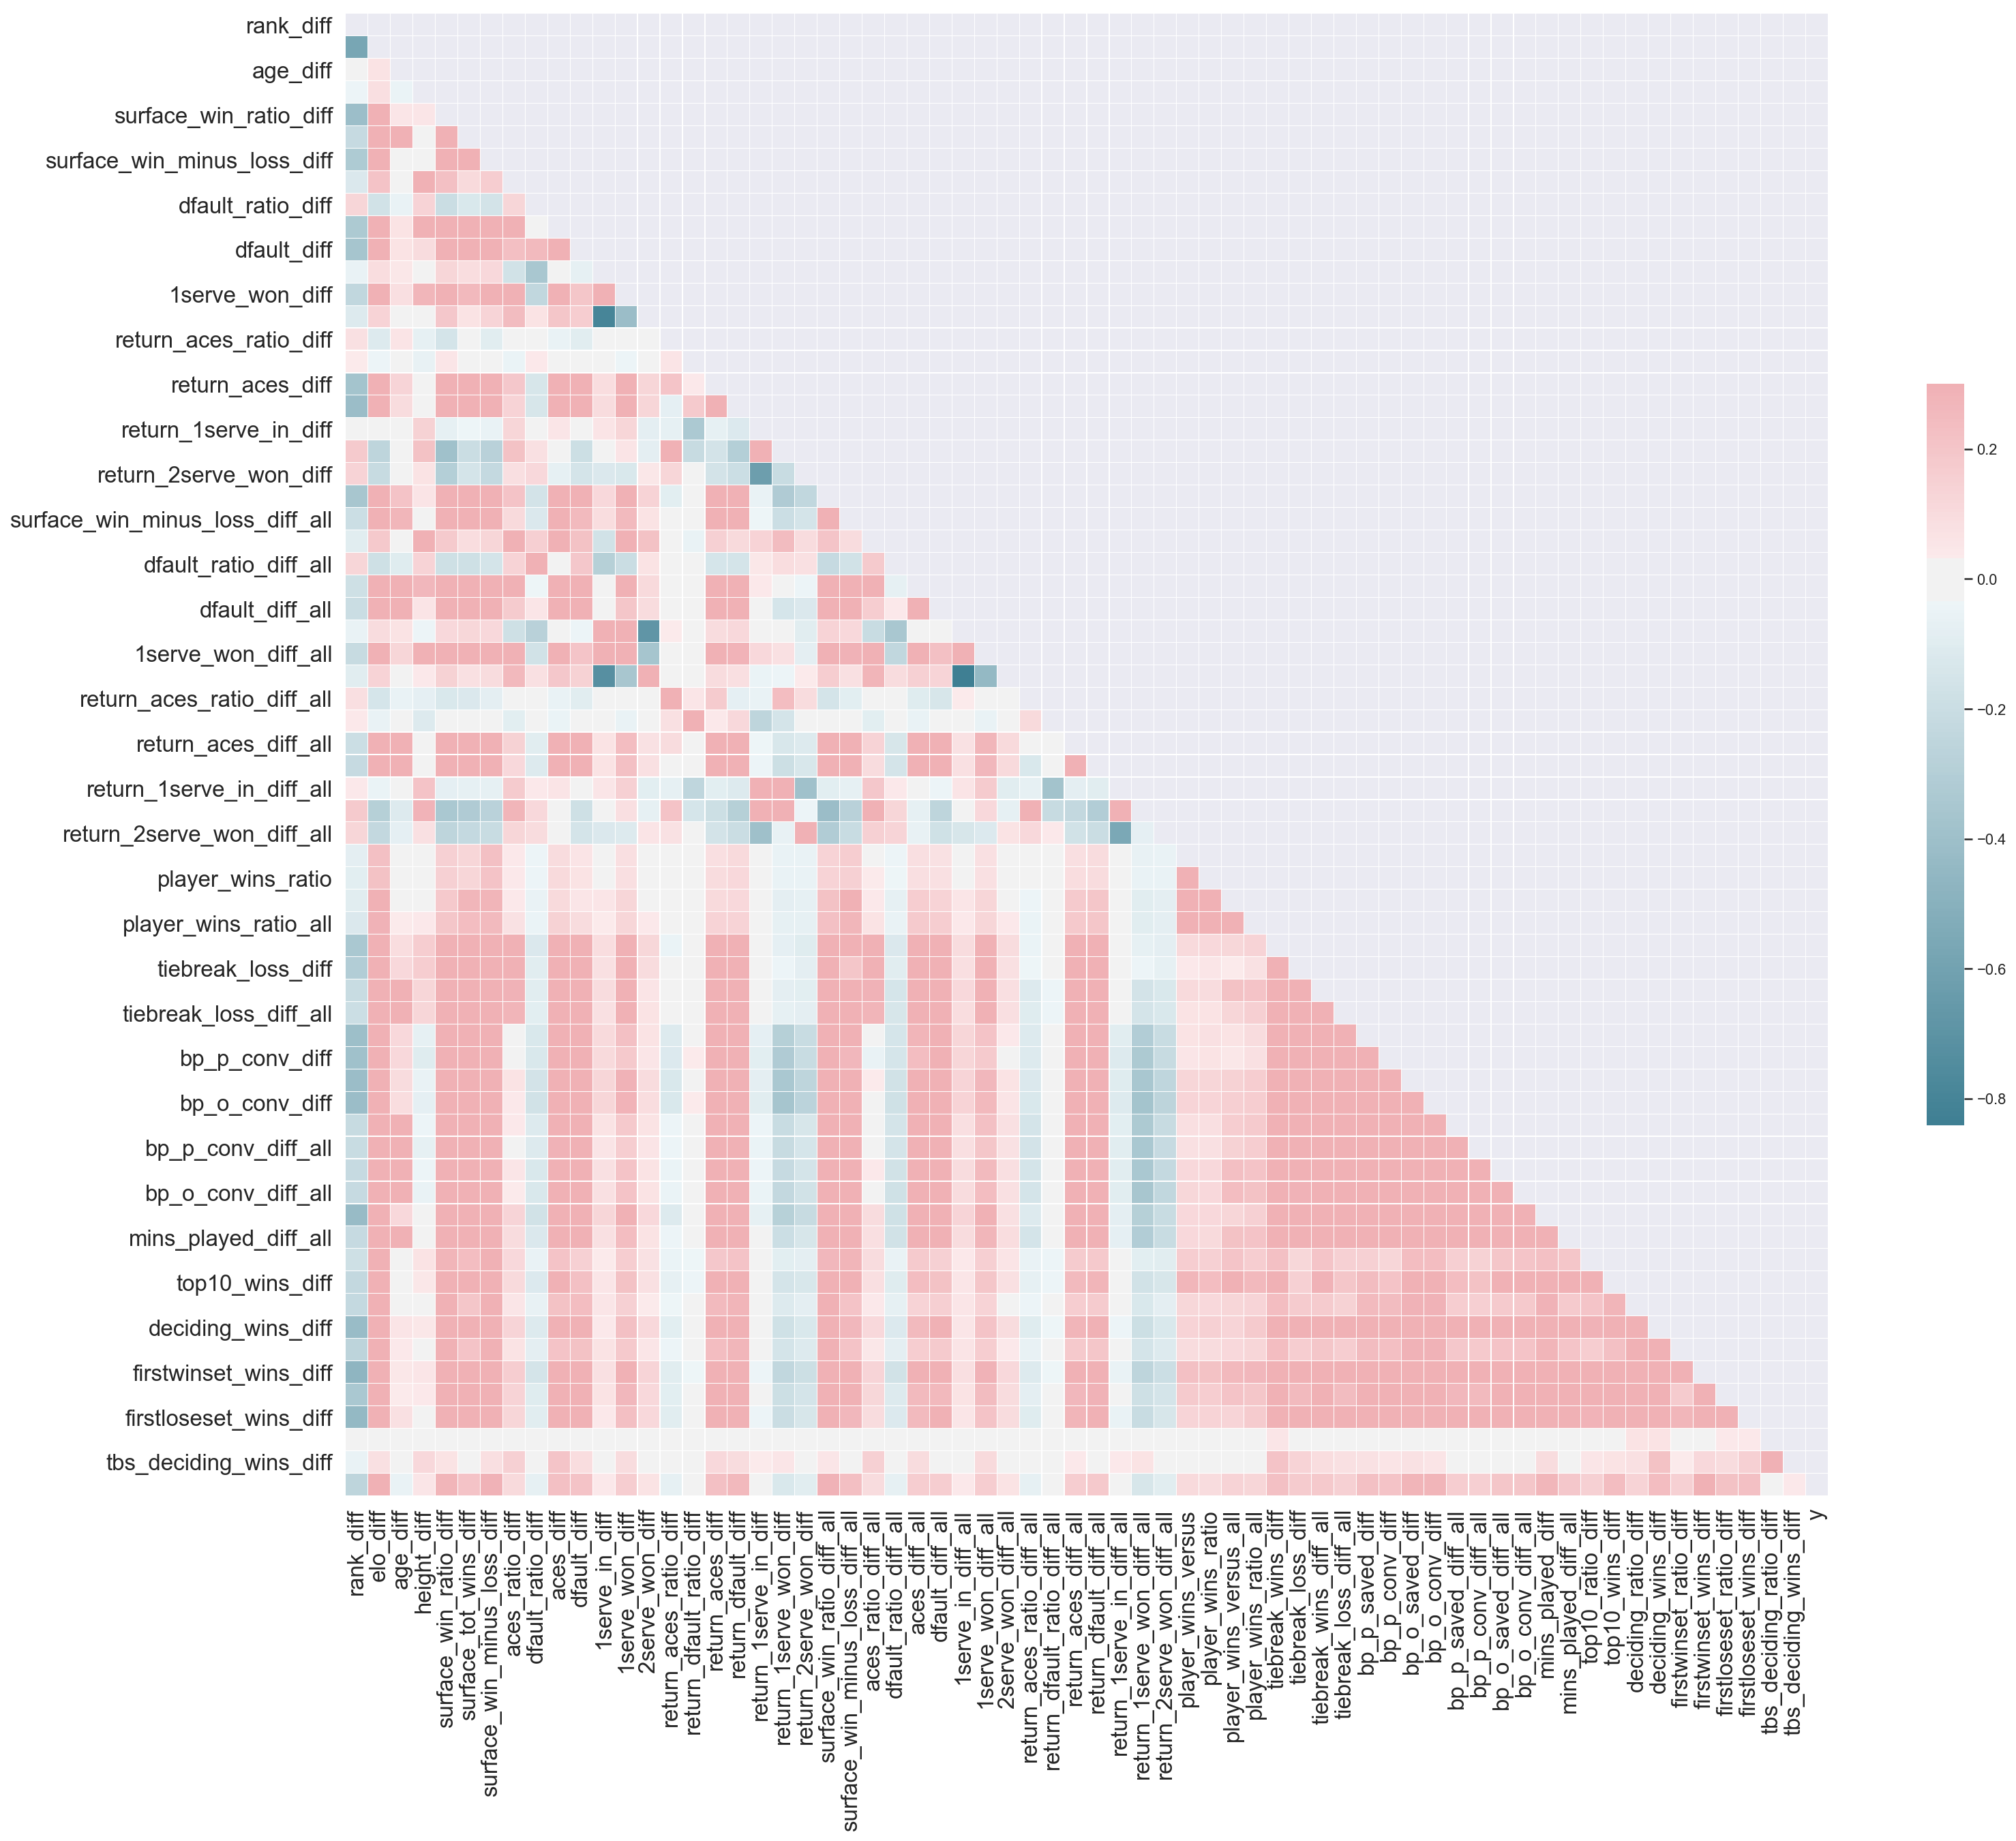

In [21]:

mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(26, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.set(font_scale=1)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5});

In [22]:
X.to_csv("X_y_symmetric2.csv",index=False)
df_filt.to_csv("filtered_all_symmetric2.csv",index=False)